In [2]:
from __future__ import print_function, division
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import pandas
import vcfnp
import allel
import os
vcfnp.__version__

def get_pops( species ):
    # load the populations files
    df_samples = pandas.read_csv(POPS_FILES_DIR+species+"_pops.txt", delimiter=" ", header=None)

    df_samples.head()
    populations = df_samples[1].unique()
    return( df_samples, populations )

/usr/local/opt/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [30]:
DATA_DIR="/Users/iovercast/Dropbox/Tumbes-Maranon-Project/Pyrad-output/Step6/"
POPS_FILES_DIR="/Users/iovercast/Dropbox/Tumbes-Maranon-Project/Fastsimcoal2/PopsFiles/"

SEQ_LENGTH = 240

specieslist = os.listdir(DATA_DIR)
print(specieslist)

['Arremon', 'Campylorhynchus', 'Melanopareia', 'Mimus', 'Saltator', 'Thamnophilus']


In [126]:
for species in specieslist:
#for species in ["Campylorhynchus"]:
    print("Doing ", species)
    
    ## Read in the genotype and variant files
    v = vcfnp.variants(DATA_DIR+species+"/outfiles/c85d6m4p3.vcf", verbose=False).view(np.recarray)
    c = vcfnp.calldata_2d(DATA_DIR+species+"/outfiles/c85d6m4p3.vcf", verbose=False).view(np.recarray)
        
    # Get the population assignments
    # Must reinitialize the df_samples np array
    #df_samples = np.empty( len(ac) )
    df_samples, populations = get_pops( species )

    pop1 = "Mar"
    pop2 = "Tum"
# Don't need this?
#    pos_all = allel.SortedIndex(range(0, len(g)))
    subpops = {
        pop1: df_samples[df_samples[1] == pop1].index,
        pop2: df_samples[df_samples[1] == pop2].index,
    }
    
    ##########################################
    ## Split the giant genotype array by locus
    ##########################################
    ## Pull out all snps per locus so we can create genotype arrays per locus
    ## This routine will split the giant genotype file read in from vcf into
    ## a list of lists of snps, one for each rad tag

    ## Counter to index through the "chromosomes" which in this case are the rad tags
    cidx = 1
    ## This list will contain all the sublists
    all_loci = []
    ## Tmp list to hold the genotype for each snp w/in a locus
    tmp_genotypes = []
    for i, chrom in enumerate(v.CHROM):
        if cidx == int(chrom):
            tmp_genotypes.append(c[i])
        else:
            #print("done - {}".format(cidx))
            if tmp_genotypes:
                all_loci.append(tmp_genotypes)
            tmp_genotypes = []
            tmp_genotypes.append(c[i])
            cidx+=1

    ##########################################
    ## Get sumstats for each locus for both pops and accumulate them in a list
    ##########################################
    pis_mar = []
    pis_tum = []
    hos_mar = []
    hes_mar = []
    hos_tum = []
    hes_tum = []
    thats_mar = []
    thats_tum = []
    tajds_mar = []
    tajds_tum = []
    fsts = []
    dxys = []
    for i in all_loci:
        tmpg = allel.GenotypeArray([x.genotype for x in i])
        #print(tmpg.n_samples)
        acs = tmpg.count_alleles_subpops(subpops)
        acu = allel.AlleleCountsArray(acs[pop1][:] + acs[pop2][:])
        #print(acs)
        flt = acu.is_segregating() & (acu.max_allele() == 1)
        #not needed?
        #pos = pos_all.compress(flt)
        genotype = tmpg.compress(flt, axis=0)
        biallelic_mar = allel.AlleleCountsArray(acs[pop1].compress(flt, axis=0)[:, :2])
        biallelic_tum = allel.AlleleCountsArray(acs[pop2].compress(flt, axis=0)[:, :2])

        # subset genotype array per population
        g_mar = tmpg.subset(range(0, len(tmpg)), np.where( df_samples[1] == pop1 )[0])
        g_tum = tmpg.subset(range(0, len(tmpg)), np.where( df_samples[1] == pop2 )[0])
        # Get per population allele counts
        ac_mar = tmpg.count_alleles(subpop = np.where( df_samples[1] == pop1 )[0])
        ac_tum = tmpg.count_alleles(subpop = np.where( df_samples[1] == pop2 )[0])

        ########################################
        # Get pi per population
        ########################################
        pi_mar = allel.stats.sequence_diversity( (1,SEQ_LENGTH), ac_mar )
        pi_tum = allel.stats.sequence_diversity( (1,SEQ_LENGTH), ac_tum )
        pis_mar.append(pi_mar)
        pis_tum.append(pi_tum)

        ########################################
        # Get average observed and expected heterozygosity per population
        #
        # May be broken...
        ########################################
        if not len(g_mar) == 0:
            ho_mar = sum(np.nan_to_num(allel.stats.heterozygosity_observed(g_mar)))/len(g_mar)
            af_mar = g_mar.count_alleles().to_frequencies()
            he_mar = np.sum(np.nan_to_num(allel.stats.heterozygosity_expected(af_mar, ploidy=2)))/len(af_mar)
            hos_mar.append(ho_mar)
            hes_mar.append(he_mar)
        if not len(g_tum) == 0:
            ho_tum = sum(np.nan_to_num(allel.stats.heterozygosity_observed(g_tum)))/len(g_tum)
            af_tum = g_tum.count_alleles().to_frequencies()
            he_tum = np.sum(np.nan_to_num(allel.stats.heterozygosity_expected(af_tum, ploidy=2)))/len(af_tum)
            hos_tum.append(ho_tum)
            hes_tum.append(he_tum)
        
        # Get Watterson's Theta per population
        ThetaHat_mar = allel.stats.diversity.watterson_theta((1, SEQ_LENGTH), ac_mar)
        ThetaHat_tum = allel.stats.diversity.watterson_theta((1, SEQ_LENGTH), ac_tum)
        thats_mar.append(ThetaHat_mar)
        thats_tum.append(ThetaHat_tum)
        
        # Get Tajima's D per population
        TajD_mar = allel.stats.diversity.tajima_d((1, SEQ_LENGTH), ac_mar )
        TajD_tum = allel.stats.diversity.tajima_d((1, SEQ_LENGTH), ac_tum )
        tajds_mar.append(TajD_mar)
        tajds_tum.append(TajD_tum)

        # Get Hudson's Fst
        num, den = allel.stats.hudson_fst(ac_mar, ac_tum)
        fsts.append(np.sum(np.nan_to_num(num)) / np.sum(np.nan_to_num(den)))
        
        # Print pairwise differences Dxy
        Dxy = allel.stats.diversity.sequence_divergence((1, SEQ_LENGTH), ac_mar, ac_tum)
        dxys.append(Dxy)

        
        ## Debug. This will print out shit tons of pi values
        #print( "Pi Mar = ", pi_mar )
        #print( "Pi Tum = ", pi_tum )
        #print( "Ho / He Mar = ", ho_mar, he_mar )
        #print( "Ho / He Tum = ", ho_tum, he_tum )
        #print( "ThetaHat Mar = ", ThetaHat_mar )
        #print( "ThetaHat Tum = ", ThetaHat_tum )
        #print( "Tajima's D Mar = ", TajD_mar )
        #print( "Tajima's D Tum = ", TajD_tum )
        #print( "Fst = {}".format(num/den))
        #print( "Dxy = ",Dxy )

    ## Done calculating across loci, now do the averages
    ## Get average pi for each pop
    avgpi_mar = sum(pis_mar)/len(pis_mar)
    avgpi_tum = sum(pis_tum)/len(pis_tum)
    print("{} pi: Mar - {}\tTum - {}".format(species, avgpi_mar, avgpi_tum))
    ## Get average Ho/He
    avgho_mar = sum(hos_mar)/len(hos_mar)
    avghe_mar = sum(hes_mar)/len(hes_mar)
    avgho_tum = sum(hos_tum)/len(hos_tum)
    avghe_tum = sum(hes_tum)/len(hes_tum)
    print("{} (Ho/He): Mar - {}/{}\tTum - {}/{}".format(species, avgho_mar, avghe_mar, avgho_tum, avghe_tum))

    filtered_thats_mar = filter(lambda v: v==v and v!=0, thats_mar)
    filtered_thats_tum = filter(lambda v: v==v and v!=0, thats_tum)
    avgthats_mar = sum(filtered_thats_mar)/len(filtered_thats_mar)
    avgthats_tum = sum(filtered_thats_tum)/len(filtered_thats_tum)
    print("{} watterson: Mar - {}\tTum - {}".format(species, avgthats_mar, avgthats_tum))

    filtered_taj_mar = filter(lambda v: v==v, tajds_mar)
    filtered_taj_tum = filter(lambda v: v==v, tajds_tum)
    avgtajd_mar = sum(filtered_taj_mar)/len(filtered_taj_mar)
    avgtajd_tum = sum(filtered_taj_tum)/len(filtered_taj_tum)
    print("{} tajima: Mar - {}\tTum - {}".format(species, avgtajd_mar, avgtajd_tum))

    filtered_fsts = filter(lambda v: v==v, fsts)
    avgfst = np.mean(filtered_fsts)
    print( "Hudson's Fst = ", avgfst )

    avgdxy = sum(dxys)/len(dxys)
    print("{} dxy: {}".format(species, avgdxy))



Doing  Arremon
Arremon pi: Mar - 0.00372955953553	Tum - 0.00580120046238
Arremon (Ho/He): Mar - 0.0883963449799/0.113483637249	Tum - 0.120920266855/0.193606320061
Arremon watterson: Mar - 0.00600300940941	Tum - 0.00659699481271
Arremon tajima: Mar - 0.252585687608	Tum - 0.0965287383262
Hudson's Fst =  0.409902174982
Arremon dxy: 0.00906666149263
Doing  Campylorhynchus
Campylorhynchus pi: Mar - 0.00190014335913	Tum - 0.00249368359047
Campylorhynchus (Ho/He): Mar - 0.107819713128/0.122989018096	Tum - 0.175527255999/0.210145148766
Campylorhynchus watterson: Mar - 0.00377517645168	Tum - 0.00334720770194
Campylorhynchus tajima: Mar - 0.0511613326313	Tum - -0.015105584548
Hudson's Fst =  0.211551092536
Campylorhynchus dxy: 0.00298214480724
Doing  Melanopareia
Melanopareia pi: Mar - 0.00277327928473	Tum - 0.00453129791408
Melanopareia (Ho/He): Mar - 0.0757543755164/0.0982431849922	Tum - 0.132231284017/0.17570835987
Melanopareia watterson: Mar - 0.00445940480735	Tum - 0.00584141739605
Melanopa

In [125]:
#num, den = allel.stats.hudson_fst(ac_mar, ac_tum)
#fst = np.sum(np.nan_to_num(num)) / np.sum(np.nan_to_num(den))
#print( "Hudson's Fst = ", fst )
#filtered_fsts = filter(lambda v: v==v, fsts)
#print(filtered_fsts)
den

array([ 0.16666667,  0.25      ,  0.33333333,  0.5       ,  0.33333333])

In [93]:
## If the test locus is bad just grab a new one
i = all_loci[4]
if True:
    if True:
        tmpg = allel.GenotypeArray([x.genotype for x in i])
        #print(tmpg.n_samples)
        acs = tmpg.count_alleles_subpops(subpops)
        acu = allel.AlleleCountsArray(acs[pop1][:] + acs[pop2][:])
        #print(acs)
        flt = acu.is_segregating() & (acu.max_allele() == 1)
        #not needed?
        #pos = pos_all.compress(flt)
        genotype = tmpg.compress(flt, axis=0)
        biallelic_mar = allel.AlleleCountsArray(acs[pop1].compress(flt, axis=0)[:, :2])
        biallelic_tum = allel.AlleleCountsArray(acs[pop2].compress(flt, axis=0)[:, :2])

        # subset genotype array per population
        g_mar = tmpg.subset(range(0, len(tmpg)), np.where( df_samples[1] == pop1 )[0])
        g_tum = tmpg.subset(range(0, len(tmpg)), np.where( df_samples[1] == pop2 )[0])

In [47]:
##########################################
## Sum across pi for all loci and divide by the total
## number of loci to get average pi per pop
##########################################

for species in specieslist:
    ## Get average pi for each pop
    avgpi_mar = sum(pis_mar)/len(pis_mar)
    avgpi_tum = sum(pis_tum)/len(pis_tum)
    print("{} pi: Mar - {}\tTum - {}".format(species, avgpi_mar, avgpi_tum))
    ## Get average Ho/He
#    avgho_mar = sum(hos_mar)/len(hos_mar)
#    avghe_mar = sum(hes_mar)/len(hes_mar)
#    avgho_tum = sum(hos_tum)/len(hos_tum)
#    avghe_tum = sum(hes_tum)/len(hes_tum)
#    print("{} (Ho/He): Mar - {}/{}\tTum - {}/{}".format(species, avgho_mar, avghe_mar, avgho_tum, avghe_tum))
    
    avgthats_mar = sum(thats_mar)/len(thats_mar)
    avgthats_tum = sum(thats_tum)/len(thats_tum)
    print("{} watterson: Mar - {}\tTum - {}".format(species, avgthats_mar, avgthats_tum))

    avgtajd_mar = sum(tajds_mar)/len(tajds_mar)
    avgtajd_tum = sum(tajds_tum)/len(tajds_tum)
    print("{} tajima: Mar - {}\tTum - {}".format(species, avgtajd_mar, avgtajd_tum))

    avgdxy = sum(dxys)/len(dxys)
    print("{} dxy: {}".format(species, avgdxy))

Arremon pi: Mar - 0.00209011462382	Tum - 0.00329014539176
Arremon watterson: Mar - nan	Tum - nan
Arremon tajima: Mar - nan	Tum - nan
Arremon dxy: 0.00438810419453
Campylorhynchus pi: Mar - 0.00209011462382	Tum - 0.00329014539176
Campylorhynchus watterson: Mar - nan	Tum - nan
Campylorhynchus tajima: Mar - nan	Tum - nan
Campylorhynchus dxy: 0.00438810419453
Melanopareia pi: Mar - 0.00209011462382	Tum - 0.00329014539176
Melanopareia watterson: Mar - nan	Tum - nan
Melanopareia tajima: Mar - nan	Tum - nan
Melanopareia dxy: 0.00438810419453
Mimus pi: Mar - 0.00209011462382	Tum - 0.00329014539176
Mimus watterson: Mar - nan	Tum - nan
Mimus tajima: Mar - nan	Tum - nan
Mimus dxy: 0.00438810419453
Saltator pi: Mar - 0.00209011462382	Tum - 0.00329014539176
Saltator watterson: Mar - nan	Tum - nan
Saltator tajima: Mar - nan	Tum - nan
Saltator dxy: 0.00438810419453
Thamnophilus pi: Mar - 0.00209011462382	Tum - 0.00329014539176
Thamnophilus watterson: Mar - nan	Tum - nan
Thamnophilus tajima: Mar - nan

In [146]:
    g = allel.GenotypeArray(c.genotype)
    
    # Get the population assignments
    # Must reinitialize the df_samples np array
    #df_samples = np.empty( len(ac) )
    df_samples, populations = get_pops( species )

    pop1 = "Mar"
    pop2 = "Tum"
    pos_all = allel.SortedIndex(range(0, len(g)))
    subpops = {
        pop1: df_samples[df_samples[1] == pop1].index,
        pop2: df_samples[df_samples[1] == pop2].index,
    }
    
    # Filter out multi-allelic and sites that don't segragate
    # in the populations
    acs = g.count_alleles_subpops(subpops)
    acu = allel.AlleleCountsArray(acs[pop1][:] + acs[pop2][:])
    flt = acu.is_segregating() & (acu.max_allele() == 1)
    print('retaining', np.count_nonzero(flt), 'biallelic SNPs')
    pos = pos_all.compress(flt)
    genotype = g.compress(flt, axis=0)
    biallelic_mar = allel.AlleleCountsArray(acs[pop1].compress(flt, axis=0)[:, :2])
    biallelic_tum = allel.AlleleCountsArray(acs[pop2].compress(flt, axis=0)[:, :2])
    
    # subset genotype array per population
    g_mar = g.subset(range(0, len(g)), np.where( df_samples[1] == pop1 )[0])
    g_tum = g.subset(range(0, len(g)), np.where( df_samples[1] == pop2 )[0])
    
    # Get per population allele counts
    ac_mar = g.count_alleles(subpop = np.where( df_samples[1] == pop1 )[0])
    ac_tum = g.count_alleles(subpop = np.where( df_samples[1] == pop2 )[0])

    # Get pi per population
    pi_mar = allel.stats.sequence_diversity( range(1, len(g)), ac_mar )
    pi_tum = allel.stats.sequence_diversity( range(1, len(g)), ac_tum )
    print( "Pi Mar = ", pi_mar )
    print( "Pi Tum = ", pi_tum )

    

retaining 34470 biallelic SNPs
Pi Mar =  0.15058086094
Pi Tum =  0.234235716219


In [170]:
## Pull out all snps per locus so we can create genotype arrays per locus
cidx = 1
all_loci = []
mygen = []
for i, chrom in enumerate(v.CHROM):
    if cidx == int(chrom):
        mygen.append(c[i])
    else:
        print("done - {}".format(cidx))
        all_loci.append(mygen)
        mygen = []
        mygen.append(c[i])
        cidx+=1
    #print([x for x in v if x.CHROM == chrom])


done - 1
done - 2
done - 3
done - 4
done - 5
done - 6
done - 7
done - 8
done - 9
done - 10
done - 11
done - 12
done - 13
done - 14
done - 15
done - 16
done - 17
done - 18
done - 19
done - 20
done - 21
done - 22
done - 23
done - 24
done - 25
done - 26
done - 27
done - 28
done - 29
done - 30
done - 31
done - 32
done - 33
done - 34
done - 35
done - 36
done - 37
done - 38
done - 39
done - 40
done - 41
done - 42
done - 43
done - 44
done - 45
done - 46
done - 47
done - 48
done - 49
done - 50
done - 51
done - 52
done - 53
done - 54
done - 55
done - 56
done - 57
done - 58
done - 59
done - 60
done - 61
done - 62
done - 63
done - 64
done - 65
done - 66
done - 67
done - 68
done - 69
done - 70
done - 71
done - 72
done - 73
done - 74
done - 75
done - 76
done - 77
done - 78
done - 79
done - 80
done - 81
done - 82
done - 83
done - 84
done - 85
done - 86
done - 87
done - 88
done - 89
done - 90
done - 91
done - 92
done - 93
done - 94
done - 95
done - 96
done - 97
done - 98
done - 99
done - 100
done - 1

In [32]:
pi_mar = allel.stats.sequence_diversity( (1,100,240), ac_mar )
pi_tum = allel.stats.sequence_diversity( (1,100,240), ac_tum )
print(pi_mar, pi_tum)
print(g_mar)

0.0 0.000789473684211
[]


# Everything below here is for testing

In [171]:
pis_mar = []
pis_tum = []
for i in all_loci:
    tmpg = allel.GenotypeArray([x.genotype for x in i])
    #print(tmpg.n_samples)
    acs = tmpg.count_alleles_subpops(subpops)
    acu = allel.AlleleCountsArray(acs[pop1][:] + acs[pop2][:])
    #print(acs)
    flt = acu.is_segregating() & (acu.max_allele() == 1)
    print('retaining', np.count_nonzero(flt), 'biallelic SNPs')
    pos = pos_all.compress(flt)
    genotype = tmpg.compress(flt, axis=0)
    biallelic_mar = allel.AlleleCountsArray(acs[pop1].compress(flt, axis=0)[:, :2])
    biallelic_tum = allel.AlleleCountsArray(acs[pop2].compress(flt, axis=0)[:, :2])

    # subset genotype array per population
    g_mar = tmpg.subset(range(0, len(tmpg)), np.where( df_samples[1] == pop1 )[0])
    g_tum = tmpg.subset(range(0, len(tmpg)), np.where( df_samples[1] == pop2 )[0])
    # Get per population allele counts
    ac_mar = tmpg.count_alleles(subpop = np.where( df_samples[1] == pop1 )[0])
    ac_tum = tmpg.count_alleles(subpop = np.where( df_samples[1] == pop2 )[0])

    # Get pi per population
    pi_mar = allel.stats.sequence_diversity( (1,240), ac_mar )
    pi_tum = allel.stats.sequence_diversity( (1,240), ac_tum )
    print( "Pi Mar = ", pi_mar )
    print( "Pi Tum = ", pi_tum )
    pis_mar.append(pi_mar)
    pis_tum.append(pi_tum)


retaining 1 biallelic SNPs
Pi Mar =  0.0
Pi Tum =  0.000789473684211
retaining 2 biallelic SNPs
Pi Mar =  0.0
Pi Tum =  0.00239898989899
retaining 4 biallelic SNPs
Pi Mar =  0.00713942307692
Pi Tum =  0.0
retaining 4 biallelic SNPs
Pi Mar =  0.00416666666667
Pi Tum =  0.0025
retaining 4 biallelic SNPs
Pi Mar =  0.0
Pi Tum =  0.00255991285403
retaining 1 biallelic SNPs
Pi Mar =  0.0
Pi Tum =  0.000462962962963
retaining 1 biallelic SNPs
Pi Mar =  0.0
Pi Tum =  0.00138888888889
retaining 5 biallelic SNPs
Pi Mar =  0.00208333333333
Pi Tum =  0.00238095238095
retaining 8 biallelic SNPs
Pi Mar =  0.00611111111111
Pi Tum =  0.0130555555556
retaining 3 biallelic SNPs
Pi Mar =  0.00104166666667
Pi Tum =  0.00178571428571
retaining 6 biallelic SNPs
Pi Mar =  0.00222222222222
Pi Tum =  0.00569444444444
retaining 1 biallelic SNPs
Pi Mar =  0.0
Pi Tum =  0.0022095959596
retaining 6 biallelic SNPs
Pi Mar =  0.00416666666667
Pi Tum =  0.00449494949495
retaining 2 biallelic SNPs
Pi Mar =  0.0
Pi Tum 

ValueError: I/O operation on closed file

In [172]:
## Get average pi for each pop
avgpi_mar = sum(pis_mar)/len(pis_mar)
avgpi_tum = sum(pis_tum)/len(pis_tum)
print(avgpi_mar, avgpi_tum)

0.003862798192 0.00641981353192


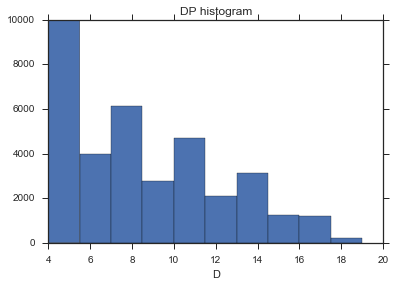

In [44]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.hist(v.NS)
ax.set_title('DP histogram')
ax.set_xlabel('D');